# Lib Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from hcdr.data.data import Data


In [2]:
%load_ext autoreload
%autoreload 2

# CSV File Imports

In [3]:
df_col_descriptions = pd.read_csv("../raw_data/HomeCredit_columns_description.csv")

Max's get data function. Tweaked to reduce load time by changing dtypes. Change nrows value to only load first nrows of csv file.  
Loads all rows when nrows=None.

In [10]:
%%time
data = Data()
df_dict = data.get_data(nrows=300_000)
df_dict.keys()

CPU times: user 6.16 s, sys: 891 ms, total: 7.05 s
Wall time: 7.05 s


dict_keys(['application_train', 'application_test', 'bureau', 'bureau_balance', 'POS_CASH_balance', 'credit_card_balance', 'previous_application', 'installments_payments'])

In [5]:
tables = ["bureau", "bureau_balance", "credit_card_balance", "POS_CASH_balance", "previous_application", "application_train", "application_test"]

# Drop Cols from Tables with Majority Missing Data

## drop_cols_function

In [36]:
def drop_cols(df_dict, missing_amt=0.3):
    dfs_dropped_missing_vals = {}
    dict_dropped_cols = {}
    for df_keys, df in df_dict.items():
        df_missing_vals=pd.DataFrame((df.isnull().sum()/df.shape[0]).sort_values(ascending=False)).reset_index().rename(columns={"index":"feature", 0:"percent_missing"})
        drop_cols = list(df_missing_vals[df_missing_vals.percent_missing >= missing_amt].feature.values)#+["FLAG_MOBIL", "FLAG_WORK_PHONE"]
        dict_dropped_cols[df_keys]=drop_cols
        df_temp = df.drop(columns=drop_cols)
        print(f"{df_keys}:       {df.shape[1]} --> {df_temp.shape[1]}. Dropped {df.shape[1] - df_temp.shape[1]} columns")
        dfs_dropped_missing_vals[df_keys] = df_temp
    return dfs_dropped_missing_vals

df_dict2 = drop_cols(df_dict, missing_amt=0.3)
df_dict2.keys()

application_train:       122 --> 72. Dropped 50 columns
application_test:       121 --> 71. Dropped 50 columns
bureau:       17 --> 13. Dropped 4 columns
bureau_balance:       3 --> 3. Dropped 0 columns
POS_CASH_balance:       8 --> 8. Dropped 0 columns
credit_card_balance:       23 --> 23. Dropped 0 columns
previous_application:       37 --> 26. Dropped 11 columns
installments_payments:       8 --> 8. Dropped 0 columns


dict_keys(['application_train', 'application_test', 'bureau', 'bureau_balance', 'POS_CASH_balance', 'credit_card_balance', 'previous_application', 'installments_payments'])

In [45]:
### TODO ###

# application train/test: Need to drop additional columns:
# "FLAG_MOBIL"      -> 99.999% of all loans include a mobile #. No value added, drop.
# "FLAG_WORK_PHONE" -> Decription and col header don't match. Drop col.

### TODO ###

# Agg dfs:

In [23]:
df_dict2.keys()

dict_keys(['bureau', 'bureau_balance', 'POS_CASH_balance', 'credit_card_balance', 'previous_application', 'installments_payments'])

In [30]:
def agg_dfs(df_dict):
    df_dict.pop('application_train', None)
    df_dict.pop('application_test', None)
    df_dict.pop('bureau_balance', None)
    
    dict_dfs_agged = {}

    for df_key, df in df_dict.items():
        dict_dfs_agged[df_key] = df.groupby(by="SK_ID_CURR").mean()
    return dict_dfs_agged

dict_dfs_agged = agg_dfs(df_dict2)

In [35]:
df_dict2["application_train"]

KeyError: 'application_train'

In [33]:
def merge_dfs(df_application, dfs_agged):
    """df_application can be either train or test df"""
    df_merged = df_application
    for df_key, df in dfs_agged.items():
        df_merged = pd.merge(df_merged, df, on="SK_ID_CURR")
    return df_merged

merge_dfs(df_dict2["application_train"], dfs_agged)

KeyError: 'application_train'

((300000,), 300000)

# preprocessing pipeline

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline()

## previous_application

In [46]:
query = "SK_ID_CURR == 100006"
dfs_dropped_missing_vals["previous_application"].groupby(by="SK_ID_CURR").count()#.query(query)

,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100006,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100007,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
100009,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
100011,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
456251,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
456253,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# Aggregation Strategies 

## application_train

In [67]:
pd.read_json(df_app_train2.info)

ValueError: Invalid file path or buffer object type: <class 'method'>

## bureau

## bureau_balance

## credit_card_balance

In [50]:
dfs_dropped_missing_vals["credit_card_balance"].groupby(by="SK_ID_CURR").count().sort_values(by="SK_ID_PREV", ascending=False)

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
199030,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
130207,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
113766,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
317899,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
317029,18,18,18,18,18,18,18,18,16,18,...,18,18,18,18,18,18,16,18,18,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353871,1,1,1,1,0,1,0,0,1,0,...,1,1,0,1,0,0,1,1,1,1
199654,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
353838,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [52]:
query = "SK_ID_CURR == 199030"
dfs_dropped_missing_vals["credit_card_balance"].query(query)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
28148,2270952,199030,-13,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
36144,2270952,199030,-56,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
43328,2270952,199030,-47,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,-174.330002,-174.330002,0.0,0,0.0,0.0,16.0,Active,0,0
51610,2270952,199030,-9,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
103915,2270952,199030,-79,0.000000,67500,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
125928,2270952,199030,-40,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
130338,2270952,199030,-36,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
136072,2270952,199030,-16,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
145921,2270952,199030,-6,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0
162785,2270952,199030,-38,0.000000,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0,0.0,0.0,16.0,Active,0,0


All columns:

In [104]:
df_credit_card_balance2.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

Months Balance >=3

In [125]:
months = -3
df_credit_card_balance3 = df_credit_card_balance2[df_credit_card_balance2.MONTHS_BALANCE >= months]

In [132]:
# Feat eng credit utilization
df_credit_card_balance3['CREDIT_UTILIZATION'] = df_credit_card_balance3['AMT_BALANCE'] / df_credit_card_balance3['AMT_CREDIT_LIMIT_ACTUAL']

<ipython-input-132-3b2b9ae7d6e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit_card_balance3['CREDIT_UTILIZATION'] = df_credit_card_balance3['AMT_BALANCE'] / df_credit_card_balance3['AMT_CREDIT_LIMIT_ACTUAL']


<AxesSubplot:>

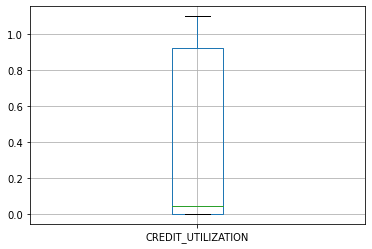

In [140]:
df_credit_card_balance3[['CREDIT_UTILIZATION']].boxplot()

In [143]:
df_credit_card_balance3.query("SK_ID_CURR == 100006")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,CREDIT_UTILIZATION
584804,1489396,100006,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0,NaN,NaN,0.0,Active,0,0,0.0
520387,1489396,100006,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0,NaN,NaN,0.0,Active,0,0,0.0
1347528,1489396,100006,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0,NaN,NaN,0.0,Active,0,0,0.0


In [ ]:
{'SK_ID_PREV'                : 'count',
'MONTHS_BALANCE'             : 'mean',
'AMT_BALANCE'                : 'median',
'AMT_CREDIT_LIMIT_ACTUAL'    : 'max',
'AMT_DRAWINGS_ATM_CURRENT'   : 'count',
'AMT_DRAWINGS_CURRENT'       : 'median',
'AMT_DRAWINGS_OTHER_CURRENT' : 'median',
'AMT_DRAWINGS_POS_CURRENT'   : 'median',
'AMT_INST_MIN_REGULARITY'    : 'median',
'AMT_PAYMENT_CURRENT'        : '',
'AMT_PAYMENT_TOTAL_CURRENT'  : '',
'AMT_RECEIVABLE_PRINCIPAL'   : '',
'AMT_RECIVABLE'              : '',
'AMT_TOTAL_RECEIVABLE'       : '',
'CNT_DRAWINGS_ATM_CURRENT'   : '',
'CNT_DRAWINGS_CURRENT'       : '',
'CNT_DRAWINGS_OTHER_CURRENT' : '',
'CNT_DRAWINGS_POS_CURRENT'   : '',
'CNT_INSTALMENT_MATURE_CUM'  : '',
'NAME_CONTRACT_STATUS'       : '',
'SK_DPD'                     : '',
'SK_DPD_DEF'                 : '',
'CREDIT_UTILIZATION'         : ['max','mean'], # Feat eng'd col
}

# agg={col : ['count', 'mean', 'min', 'max', "sum", "median", "nunique"] for col in df_xxxxxxxxxx.columns.values}

In [134]:
# Drop cat cols
df_credit_card_balance4 = df_credit_card_balance3.select_dtypes(exclude="object")

In [135]:
df_credit_card_balance4.groupby(by="SK_ID_CURR").agg(['count', 'mean', 'min', 'max', "sum", "nunique"])

SK_ID_PREV                                                \
                count       mean      min      max      sum nunique   
SK_ID_CURR                                                            
100006              3  1489396.0  1489396  1489396  4468188       1   
100011              2  1843384.0  1843384  1843384  3686768       1   
100013              3  2038692.0  2038692  2038692  6116076       1   
100021              2  2594025.0  2594025  2594025  5188050       1   
100028              3  1914954.0  1914954  1914954  5744862       1   
...               ...        ...      ...      ...      ...     ...   
100900              2  1772894.0  1772894  1772894  3545788       1   
100902              3  1331030.0  1331030  1331030  3993090       1   
100906              3  1682579.0  1682579  1682579  5047737       1   
100912              3  1559985.0  1559985  1559985  4679955       1   
100913              1  1851029.0  1851029  1851029  1851029       1   

           MONTHS_BALANCE               ... SK_DPD_DEF                  \
                    count mean min max  ...        min max sum nunique   
SK_ID_CURR                              ...                              
100006                  3 -2.0  -3  -1  ...          0   0   0       1   
100011                  2 -2.5  -3  -2  ...          0   0   0       1   
100013                  3 -2.0  -3  -1  ...          0   0   0       1   
100021                  2 -2.5  -3  -2  ...          0   0   0       1   
100028                  3 -2.0  -3  -1  ...          0   0   0       1   
...                   ...  ...  ..  ..  ...        ...  ..  ..     ...   
100900                  2 -2.5  -3  -2  ...          0   0   0       1   
100902                  3 -2.0  -3  -1  ...          0   0   0       1   
100906                  3 -2.0  -3  -1  ...          0   0   0       1   
100912                  3 -2.0  -3  -1  ...          0   0   0       1   
100913                  1 -2.0  -2  -2  ...          0   0   0       1   

           CREDIT_UTILIZATION                                                  
                        count      mean       min       max       sum nunique  
SK_ID_CURR                                                                     
100006                      3  0.000000  0.000000  0.000000  0.000000       1  
100011                      2  0.000000  0.000000  0.000000  0.000000       1  
100013                      3  0.000000  0.000000  0.000000  0.000000       1  
100021                      2  0.000000  0.000000  0.000000  0.000000       1  
100028                      3  0.121878  0.089875  0.165937  0.365635       3  
...                       ...       ...       ...       ...       ...     ...  
100900                      0       NaN       NaN       NaN  0.000000       0  
100902                      0       NaN       NaN       NaN  0.000000       0  
100906                      3  1.028272  1.023489  1.030674  3.084816       3  
100912                      3  0.677429  0.195018  0.941310  2.032287       3  
100913                      1  0.897687  0.897687  0.897687  0.897687       1  

[261 rows x 132 columns]

In [139]:
SK_ID_CURR = 100011
df_credit_card_balance4[df_credit_card_balance4.SK_ID_CURR==SK_ID_CURR].sort_values(by="SK_ID_PREV").head(60)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,CREDIT_UTILIZATION
2739019,1843384,100011,-2,0.0,90000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,33.0,0,0,0.0
3496910,1843384,100011,-3,0.0,90000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,0.0,33.0,0,0,0.0


## POS_CASH_balance

## previous_application

In [35]:
df_app_train2.SK_ID_CURR.nunique(), df_bureau2.SK_ID_CURR.nunique()

(10000, 1830)

In [37]:
df_merged = pd.merge(df_app_train2, df_bureau2, on="SK_ID_CURR", how="inner")
df_merged.head(60)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-103,0,NaN,0,31988.565,0.0,0.0,Credit card,-24
1,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-645,0,85.0,0,120735.000,0.0,0.0,Consumer credit,-34
2,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-1121,0,-911.0,0,19071.000,NaN,0.0,Consumer credit,-906
3,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-1437,0,-1072.0,0,135000.000,0.0,0.0,Consumer credit,-1185
4,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-476,0,NaN,0,0.000,0.0,0.0,Credit card,-47
5,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-1125,0,-1038.0,0,40761.000,NaN,0.0,Credit card,-1038
6,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-1042,0,780.0,0,450000.000,245781.0,0.0,Consumer credit,-7
7,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,currency 1,-1043,0,62.0,0,67500.000,NaN,0.0,Credit card,-758
8,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,currency 1,-606,0,1216.0,0,810000.000,0.0,0.0,Credit card,-43
9,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,currency 1,-775,0,-420.0,0,72652.500,0.0,0.0,Consumer credit,-550


In [25]:
df_merged.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY_x',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_

In [38]:
df_merged.SK_ID_CURR.nunique()

1558

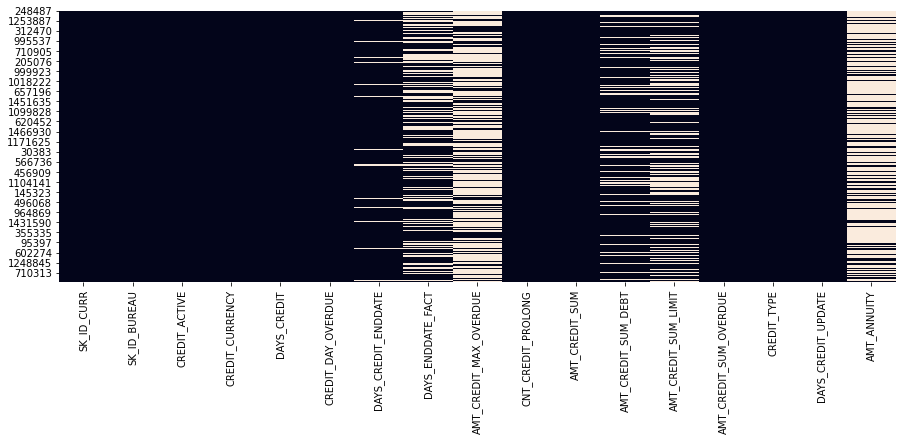

In [27]:
plt.subplots(figsize=(15,5))
sns.heatmap(df_bureau.isnull(),cbar=False);

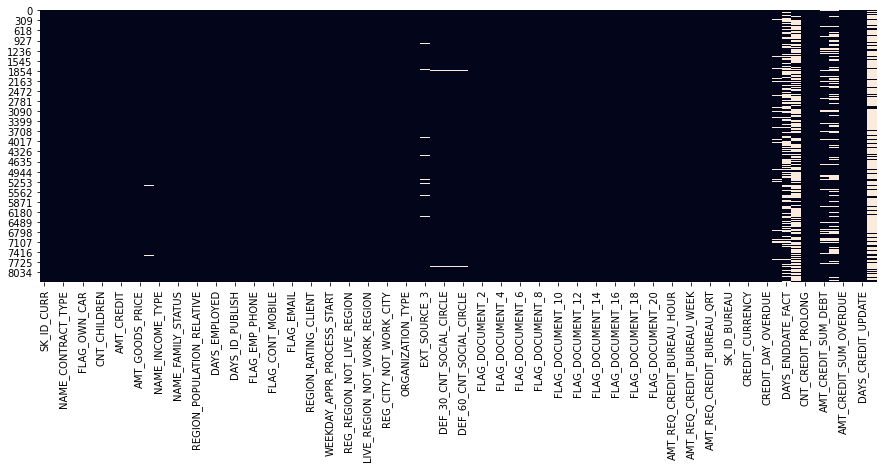

In [28]:
plt.subplots(figsize=(15,5))
sns.heatmap(df_merged.isnull(),cbar=False);

# Pipeline